# Causal Impact

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fralfaro/portfolio/blob/main/docs/blog/posts/2022/2022-10-12-implicit.ipynb)
[![](https://img.shields.io/static/v1?label=fastpages&message=link&color=57aeac&labelColor=black&style=flat&logo=)](https://fralfaro.github.io/ds_blog/python/2022/03/16/polars.html)

## Introducción

El paquete `CausalImpact` creado por Google estima el impacto de una intervención en una serie temporal. Por ejemplo, ¿cómo afecta una nueva función en una aplicación el tiempo de los usuarios en la aplicación?


En este tutorial, hablaremos sobre cómo usar el paquete de Python `CausalImpact` para hacer inferencias causales de series de tiempo. Aprenderás:
* ¿Cómo establecer los períodos previo y posterior para el análisis de impacto causal?
* ¿Cómo realizar inferencias causales sobre datos de series temporales?
* ¿Cómo resumir los resultados del análisis de causalidad y crear un informe?
* ¿Cuáles son las diferencias entre los paquetes python y R para `CausalImpact`?


## Importar librerías

En primer lugar, instalemos `pycausalimpac` para el análisis causal de series de tiempo.

In [1]:
# Install python version of causal impact
#!pip install pycausalimpact

Una vez completada la instalación, podemos importar las bibliotecas.
* `pandas`, `numpy` y `datetime` se importan para el procesamiento de datos.
* `ArmaProcess` se importa para la creación de datos de series temporales sintéticas.
* `matplotlib` y `seaborn` son para visualización.
* `CausalImpact` es para la estimación de los efectos del tratamiento de series de tiempo.

In [2]:
# Data processing
import pandas as pd
import numpy as np
from datetime import datetime

# Create synthetic time-series data
from statsmodels.tsa.arima_process import ArmaProcess

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Causal impact
from causalimpact import CausalImpact

## Crear el conjunto de datos

Crearemos un conjunto de datos de series de tiempo sintético para el análisis de impacto causal. El beneficio de usar un conjunto de datos sintético es que podemos validar la precisión de los resultados del modelo.

El paquete CausalImpact requiere dos tipos de series temporales:
* Una serie temporal de respuesta que se ve directamente afectada por la intervención.
* Y una o más series temporales de control que no se ven afectadas por la intervención.

La idea es construir un modelo de serie de tiempo para predecir el resultado contrafáctico. En otras palabras, el modelo utilizará la serie temporal de control para predecir cuál habría sido el resultado de la serie temporal de respuesta si no hubiera habido intervención.

En este ejemplo, creamos una variable de serie temporal de respuesta y una variable de serie temporal de control.
* Para que el conjunto de datos sea reproducible, se establece una semilla aleatoria al comienzo del código.
* Luego se crea un proceso de promedio móvil autorregresivo (ARMA). La parte autorregresiva (AR) tiene dos coeficientes 0,95 y 0,05, y la parte de media móvil (MA) tiene dos coeficientes 0,6 y 0,3.
* Después de crear el proceso de media móvil autorregresiva (ARMA), se generan 500 muestras a partir del proceso.
* La variable de serie temporal de control `X` se crea añadiendo un valor constante de 10 a los valores generados.
* La variable de serie temporal de respuesta `y` es una función de la variable de serie temporal de control `X`. Es igual a 2 veces `X` más un valor aleatorio.
* La intervención ocurre en el índice de 300, y el verdadero impacto causal es 10.

In [3]:
# Set up a seed for reproducibility
np.random.seed(42)

# Autoregressive coefficients
arparams = np.array([.95, .05])

# Moving average coefficients
maparams = np.array([.6, .3])

# Create a ARMA process
arma_process = ArmaProcess.from_coeffs(arparams, maparams)

# Create the control time-series
X = 10 + arma_process.generate_sample(nsample=500)

# Create the response time-series
y = 2 * X + np.random.normal(size=500)

# Add the true causal impact
y[300:] += 10

Una serie de tiempo generalmente tiene una variable de tiempo que indica la frecuencia de los datos recopilados. Creamos 500 fechas a partir del 1 de enero de 2021 usando la función pandas `date_range`, lo que indica que el conjunto de datos tiene datos diarios.

Después de eso, se crea un marco de datos de pandas con la variable de control `X`, la variable de respuesta es `y` y las `dates` como índice.

In [4]:
# Create dates
dates = pd.date_range('2021-01-01', freq='D', periods=500)

# Create dataframe
df = pd.DataFrame({'dates': dates, 'y': y, 'X': X}, columns=['dates', 'y', 'X'])

# Set dates as index
df.set_index('dates', inplace=True)

# Take a look at the data
df.head()

,y,X
dates,,
2021-01-01,21.919606,10.496714
2021-01-02,23.172702,10.631643
2021-01-03,21.278713,11.338640
2021-01-04,26.909878,13.173454
2021-01-05,27.260727,13.955685


## Períodos anteriores y posteriores

Estableceremos los periodos de pre y post intervención. Usando `df.index`, podemos ver que la fecha de inicio de la serie temporal es `2021-01-01`, la fecha de finalización de la serie temporal es `2022-05-15` y la fecha de inicio del tratamiento es `2021- 10-28`.

In [5]:
# Print out the time series start date
print(f'The time-series start date is :{df.index.min()}')

# Print out the time series end date
print(f'The time-series end date is :{df.index.max()}')

# Print out the intervention start date
print(f'The treatment start date is :{df.index[300]}')

The time-series start date is :2021-01-01 00:00:00
The time-series end date is :2022-05-15 00:00:00
The treatment start date is :2021-10-28 00:00:00


A continuación, visualicemos los datos de la serie temporal.

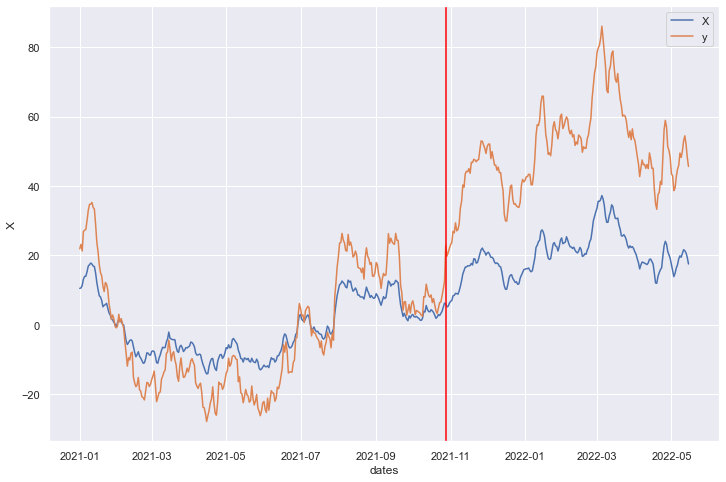

In [6]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=df.index, y=df['X'])
sns.lineplot(x=df.index, y=df['y'])
plt.axvline(x= df.index[300], color='red')
plt.legend(labels = ['X', 'y'])
plt.show()

En el gráfico, la línea azul es la serie temporal de control, la línea naranja es la serie temporal de respuesta y la línea vertical roja representa la fecha de inicio de la intervención.

Podemos ver que antes de la intervención, las series temporales de control y respuesta tienen valores similares. Después de la intervención, la serie de tiempo de respuesta tiene consistentemente valores más altos que la serie de tiempo de control.

El paquete `CausalImpact` de python requiere las entradas de los períodos anterior y posterior en un formato de lista. El primer elemento de la lista es el índice inicial y el último elemento de la lista es el índice final.

La fecha de inicio de la intervención es `2021-10-28`, por lo que el período previo finaliza en `2021-10-27`.

In [7]:
# Set pre-period
pre_period = [str(df.index.min())[:10], str(df.index[299])[:10]]

# Set post-period
post_period = [str(df.index[300])[:10], str(df.index.max())[:10]]

# Print out the values
print(f'The pre-period is {pre_period}')
print(f'The post-period is {post_period}')

The pre-period is ['2021-01-01', '2021-10-27']
The post-period is ['2021-10-28', '2022-05-15']


## Diferencias sin procesar

Calcularemos la diferencia bruta entre los períodos previo y posterior.

Podemos ver que el promedio diario previo al tratamiento es -1,64, el promedio diario posterior al tratamiento es 50,08 y la diferencia bruta entre el tratamiento previo y posterior es 51,7, que es mucho mayor que el verdadero impacto causal de 10.

Sin análisis de causalidad, sobreestimaremos el impacto causal.

In [8]:
# Calculate the pre-daily average
pre_daily_avg = df['y'][:300].mean()

# Calculate the post-daily average
post_daily_avg = df['y'][300:].mean()

# Print out the results
print(f'The pre-treatment daily average is {pre_daily_avg}.')
print(f'The post-treatment daily average is {post_daily_avg}.')
print(f'The raw difference between the pre and the post treatment is {post_daily_avg - pre_daily_avg}.')

The pre-treatment daily average is -1.6403416947312546.
The post-treatment daily average is 50.08461262581729.
The raw difference between the pre and the post treatment is 51.72495432054855.


## Causal Impact en series de tiempo

ejecutaremos el análisis de impacto causal sobre la serie temporal.

El análisis de causalidad tiene dos supuestos:
* **Supuesto 1**: Hay una o más series temporales de control que están altamente correlacionadas con la variable de respuesta, pero que no se ven afectadas por la intervención. La violación de esta suposición puede dar lugar a conclusiones erróneas sobre la existencia, la dirección o la magnitud del efecto del tratamiento.
* **Supuesto 2**: La correlación entre el control y la serie temporal de respuesta es la misma para antes y después de la intervención.

Los datos de series de tiempo sintéticos que creamos satisfacen las dos suposiciones.

El paquete `CausalImpact` de python tiene una función llamada `CausalImpact` que implementa un modelo de serie de tiempo estructural bayesiano (BSTS) en el backend. Tiene tres entradas requeridas:
* `data` toma el nombre del dataframe de python.
* `pre_period` toma los valores de índice inicial y final para el período previo a la intervención.
* `post_period` toma los valores de índice inicial y final para el período posterior a la intervención.

Después de guardar el objeto de salida en una variable llamada `impact`, podemos ejecutar `impact.plot()` para visualizar los resultados.

C:\Users\franc\AppData\Local\pypoetry\Cache\virtualenvs\basic-tools-a_KeXlN7-py3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\franc\AppData\Local\pypoetry\Cache\virtualenvs\basic-tools-a_KeXlN7-py3.8\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(
C:\Users\franc\AppData\Local\pypoetry\Cache\virtualenvs\basic-tools-a_KeXlN7-py3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_da

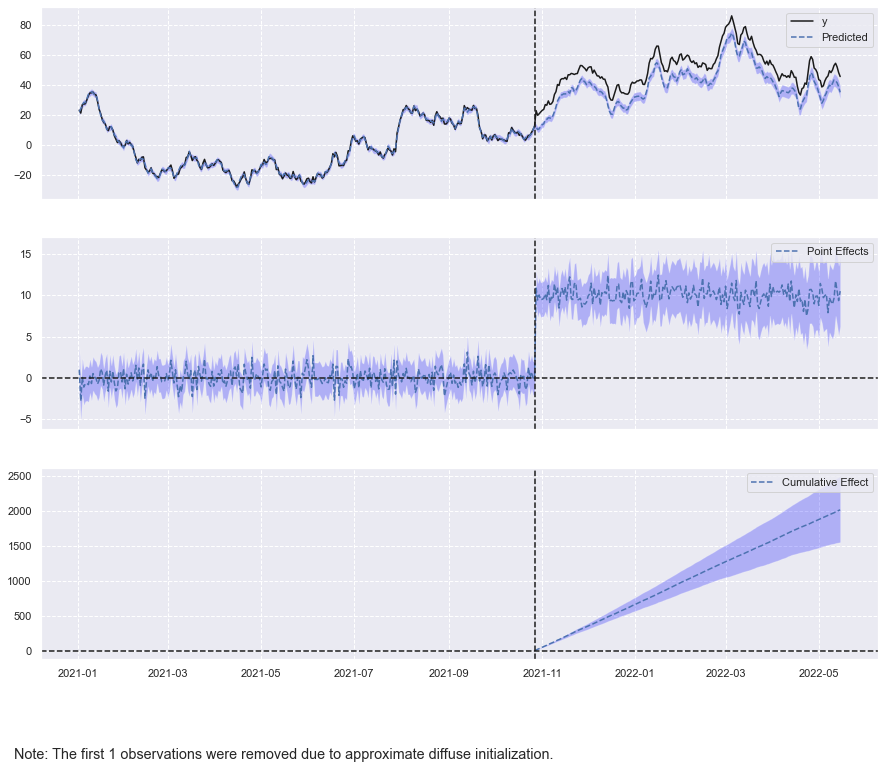

In [9]:
# Causal impact model
impact = CausalImpact(data=df, pre_period=pre_period, post_period=post_period)

# Visualization
impact.plot()

plt.show()

La visualización consta de tres gráficos:
* El primer gráfico traza los valores contrafactuales pronosticados y los valores reales para el período posterior.
* El segundo gráfico representa los efectos puntuales, que son las diferencias entre los valores reales y los previstos. Podemos ver que los valores de los efectos de puntos anteriores al período están alrededor de 0, y los valores de los efectos de puntos posteriores al período están alrededor del impacto real de 10.
* El tercer gráfico traza el efecto acumulativo, que es la suma acumulativa de los efectos de puntos del segundo gráfico.

## Resumen (Causal Impact)

Resumiremos el impacto causal de la intervención para la serie temporal.

El resumen de `impact.summary()` nos dice que:
* El promedio posterior a la intervención real es 50,08 y el promedio posterior a la intervención pronosticado es 40,3.
* El efecto causal absoluto es 10,06, que está muy cerca del verdadero impacto de 10 y mucho mejor que la diferencia bruta de 51,7.
* El efecto causal relativo es del 25,12%.
* La probabilidad posterior de un efecto causal es del 100%, lo que demuestra que el modelo tiene mucha confianza en que existe el impacto causal.

In [10]:
# Causal impact summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    50.08              10016.92
Prediction (s.d.)         40.03 (1.2)        8005.58 (239.36)
95% CI                    [37.64, 42.33]     [7527.6, 8465.89]

Absolute effect (s.d.)    10.06 (1.2)        2011.34 (239.36)
95% CI                    [7.76, 12.45]      [1551.03, 2489.32]

Relative effect (s.d.)    25.12% (2.99%)     25.12% (2.99%)
95% CI                    [19.37%, 31.09%]   [19.37%, 31.09%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Podemos imprimir la versión del informe del resumen usando la opción `output='report'`.

In [11]:
# Causal impact report
print(impact.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 50.08. By contrast, in the absence of an
intervention, we would have expected an average response of 40.03.
The 95% interval of this counterfactual prediction is [37.64, 42.33].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 10.06 with a 95% interval of
[7.76, 12.45]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 10016.92.
By contrast, had the intervention not taken place, we would have expected
a sum of 8005.58. The 95% interval of this prediction is [7527.6, 8465.89].


The above results are given in terms of absolute numbers. In relative
terms, the response var

## CausalImpact:  Python vs R

Hablaremos sobre las diferencias del paquete `CausalImpact` de Google entre Python y R.

El paquete python fue portado desde el paquete R, por lo que la mayoría de las veces los dos paquetes producen resultados similares, pero a veces producen resultados diferentes.

Las diferencias son causadas por suposiciones para inicializaciones previas, el proceso de optimización y los algoritmos de implementación.

La documentación del paquete `pycausalimpact` recomienda encarecidamente establecer `prior_level_sd` en `Ninguno`, lo que permitirá que `statsmodel` realice la optimización para el componente anterior en el nivel local.

En base a esta sugerencia, se crea una versión con la opción `prior_level_sd=None`.

C:\Users\franc\AppData\Local\pypoetry\Cache\virtualenvs\basic-tools-a_KeXlN7-py3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\franc\AppData\Local\pypoetry\Cache\virtualenvs\basic-tools-a_KeXlN7-py3.8\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize, prior_level_sd. After release 0.14, this will raise.
  warnings.warn(
C:\Users\franc\AppData\Local\pypoetry\Cache\virtualenvs\basic-tools-a_KeXlN7-py3.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.

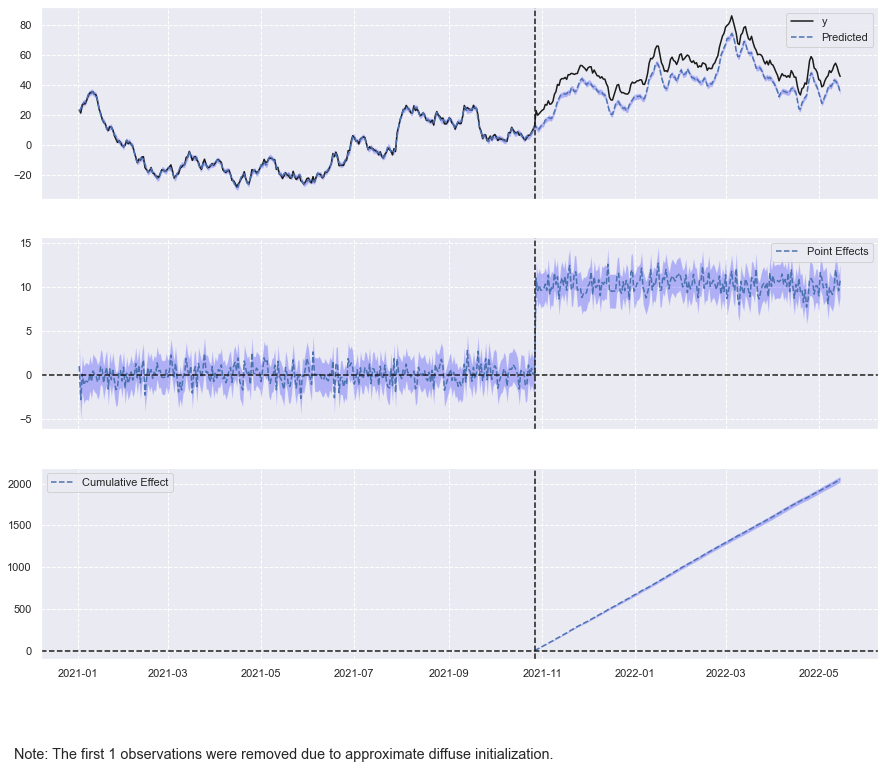

In [12]:
# Causal impact model without prior level sd
impact_no_prior_level_sd = CausalImpact(df, pre_period, post_period, prior_level_sd=None)

# Plot the results
impact_no_prior_level_sd.plot()

Podemos ver que los valores de estimación puntual son similares, pero las desviaciones estándar son más pequeñas para la estimación.

In [13]:
# Print out the summary
print(impact_no_prior_level_sd.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    50.08              10016.92
Prediction (s.d.)         39.84 (0.09)       7967.47 (18.41)
95% CI                    [39.65, 40.01]     [7929.85, 8001.99]

Absolute effect (s.d.)    10.25 (0.09)       2049.45 (18.41)
95% CI                    [10.07, 10.44]     [2014.93, 2087.08]

Relative effect (s.d.)    25.72% (0.23%)     25.72% (0.23%)
95% CI                    [25.29%, 26.19%]   [25.29%, 26.19%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


## Ajuste de hiperparámetros

Para aprender a ajustar los hiperparámetros del modelo de impacto causal de series temporales con el paquete CausalImpact de python, consulte eltutorial [Hyperparameter Tuning for Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-for-time-series-causal-impact-analysis-in-python-c8f7246c4d22)

## Referencias

* [Inferring causal impact using Bayesian structural time-series models](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/41854.pdf).
* [Time Series Causal Impact Analysis in Python | Machine Learning](https://www.youtube.com/watch?v=wdXTb9g1-w0&ab_channel=GrabNGoInfo).
* [Inferring the effect of an event using CausalImpact by Kay Brodersen](https://www.youtube.com/watch?v=GTgZfCltMm8&ab_channel=BigThingsConference).